# Probablistic Models - From Scratch! <br>
In the following notebook, we implement probablistic models using SKlearn and from Scratch. <br>
We also use a logistic regression as the base model, to be compare model preformance. 

In [35]:
# import relevant libraries
import numpy as np
import pickle as pickle
import matplotlib.pyplot as plt
import sklearn.linear_model as lin
import sklearn.neural_network as nn
import sklearn.utils

from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [36]:
# Read in the data
with open("/home/tahir/Desktop/Datasets/dataA2Q2.pickle", "rb") as file:
    dataTrain, dataTest = pickle.load(file)
Xtrain, Ttrain = dataTrain
Xtest, Ttest = dataTest

## Exploratory Data Analysis

<Figure size 432x288 with 0 Axes>

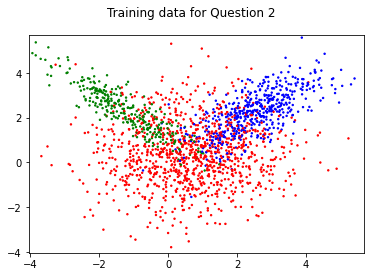

In [37]:
def plot_data(X,T):
    """
    Return the plot with 0.1 margins, and colours with different classes.
    """
    lowerMargin = np.min(X[:,0]) - 0.1 
    upperMargin = np.max(X[:,1]) + 0.1
    colors = np.array(["red", "blue", "green"])

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], s=2, c=colors[T]) # scatter plot
    plt.xlim(lowerMargin, upperMargin)
    plt.ylim(lowerMargin, upperMargin)
    return None

#Plotting 
plt.figure()
# pass in the training data
plot_data(Xtrain,Ttrain)
plt.suptitle("Training data for Question 2")
plt.show()
plt.close() 
print(" ")

## Multi-Class Logistic Regression (Base Model)

So now that we know what our data looks like, lets implement a base model <br>
This model will be a multiclass logistic regression. 

In [43]:
# Base Model - Sklearn
# Create a classification object, clf
clf_LR = lin.LogisticRegression(solver = "lbfgs", multi_class="multinomial")
clf_LR.fit(Xtrain,Ttrain) # Learn a multi-nomial logistic-regression classifier
accuracy1 = clf_LR.score(Xtest,Ttest) # Get accuracy
print(accuracy1)

0.7766666666666666


In [44]:
# Base Model - Calculating the accuracy from scratch
def accuracyLR(clf, X, T):
    """
     Compute the accuracy of the multinomial Logistic regression classifier
    """
    # Compute the vectorized multiple regression 
    # Our regression model
    z =  clf.intercept_ + np.matmul(X, clf.coef_.T)  # Compute the vectorized multiple regression 
    # Normally we use softmax to transform it into probabilities for each class, which sum to 1. 
    # However, we don't actually need that for prediction itself.
    # Take the maximum value from each row
    labeled = np.argmax(z, axis = 1)
    # Count how many were labeled correctly, and divide by N. 
    return np.mean(labeled==T)
# Compare Accuracy 1 vs accuracy 2 -- Nicely done!
accuracy2 = accuracyLR(clf_LR, Xtest, Ttest)
difference = accuracy2 - accuracy1
print("Accuracy1 is: ", accuracy1)
print("Accuracy2 is: ", accuracy2)
print("The difference is: ", difference)

Accuracy1 is:  0.7766666666666666
Accuracy2 is:  0.7766666666666666
The difference is:  0.0


## Quadratic Discriminant Analysis

In [40]:
# Gaussian Discriminant Analysis, Method 1 for calculating accuracy. 
clf = QuadraticDiscriminantAnalysis(store_covariance=True)
clf.fit(Xtrain,Ttrain)
accuracy1 = clf.score(Xtest,Ttest) 

# Calculate QDA accuracies by ourselves
def accuracyQDA(clf,X,T):
    """
    Compute and return the accuracy of Quadratic Discriminant Analysis classifier

    Parameters
    ----------
    clf : QDA Classifier.
    X : Training Data.
    T : True Labels.

    Returns
    -------
    Accuracy of the classifier.

    """
    # Get the corresponding attributes from the QDA classifier 
    mu, cov, priors = clf.means_,  clf.covariance_ , clf.priors_

    # Initialize an empty array to store the prosterior probabilities 
    Prosteriors = np.zeros(shape=(X.shape[0],len(mu)))  # This will be of shape (1800,3). 

    # For each class
    for i in range(len(mu)):
        # Get the class likihood
        pdf = multivariate_normal.pdf(X, mu[i], cov[i]) # Get the P(x|class)
        # Compute the posterior probabilities, by doing class likihood * prior belief
        Prosteriors[:, i] =  pdf*priors[i] # Numerator of the bayes class. 

    # predict the function -- Don't need p(x), the denominator for just prediction
    y = np.argmax(Prosteriors,axis=1)

    return np.mean(y==T)

accuracy2 = accuracyQDA(clf, Xtest, Ttest)
difference = accuracy2 - accuracy1
print("Accuracy1 is: ", accuracy1)
print("Accuracy2 is: ", accuracy2)
print("The difference is: ", difference)

Accuracy1 is:  0.8227777777777778
Accuracy2 is:  0.8227777777777778
The difference is:  0.0


## Gaussian Naive Bayes Model

In [62]:
clf = GaussianNB()  # Gaussian Naive Bayes Classifier
clf.fit(Xtrain,Ttrain)  # Fit the data to the model
accuracy1 = clf.score(Xtest,Ttest) # Compute the score

In [66]:
def MultivariateNormalNB(X, T, mu, sigma, priors):
    """ 
    Gaussian density which will be used to fit the data
    """
    # Broadcasting to avoid use of loops
    m, n = X.shape
    X = X.reshape([m, 1, n])
    mu = mu.reshape([1, mu.shape[0], n])
    
    # Computing class conditional densities
    class_likihood = np.exp(-((X - mu)**2)/(2*sigma))
    class_likihood /= np.sqrt(2*np.pi*sigma)
    class_likihood = np.prod(class_likihood, axis=2)

    return class_likihood 

In [67]:
# Method 2 
def accuracyNB(clf,X,T):
    """
    Naive bayes classifier

    Parameters
    ----------
    clf : The NB Classifier 
    X : The training data matrix
    T : The corresponding output 

    Returns
    -------
    Accuracy2.
    """
    
    # Get the mean, standard deviation and priors from the classifier
    mu, sigma, priors = clf.theta_,  clf.sigma_, clf.class_prior_
    
    # Get the class likihood
    class_likihood = MultivariateNormalNB(X, T, mu, sigma, priors)
    
    # Apply bayes rule
    posteriors =  class_likihood * priors
   
    # Predict and get accuracy2
    y = np.argmax(posteriors, axis=1)
    accuracy2 = np.mean(y == T)
    return accuracy2 

accuracy2 = accuracyNB(clf, Xtest, Ttest)
difference = accuracy1 - accuracy2
print("Accuracy1 is: ", accuracy1)
print("Accuracy2 is: ", accuracy2)
print("The difference is: ", difference)

Accuracy1 is:  0.7838888888888889
Accuracy2 is:  0.7838888888888889
The difference is:  0.0
